## Import Libraries and Data

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data_path = "forecasting_case_study.xlsx"
sales_data = pd.read_excel(data_path)
sales_data.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0
3,SKU1,2017-02-26,26789,0.00,1,0,1,0.0,0,0,0,0
4,SKU1,2017-03-05,41999,0.17,0,0,0,0.0,0,0,0,0


# Prediction Models

We will model each product separately, and instead of pass in the date, we will use the month as a variable (this is the seasonality), since the dates recorded are different for each year. (And we are keeping the information since we want to consider the effect of time of the year). We will first model for `SKU1`, then run the function for all products.

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    result = adfuller(data['Sales'])
    print('p-value: %f' % result[1])

Since the p-value is smaller than the standard critical value 0.05, we can conlude that the data is stationary and no transformation is needed.

## Classical Models
### ARIMA

In [15]:
from scipy.stats import boxcox
def get_product_data(product):
    product_data = sales_data[sales_data["Product"] == product]
    product_data['date'] = pd.to_datetime(product_data['date'])
    product_data = product_data.set_index(product_data['date'])
    # We are doing box-cox transformation because this is what we found to be the best from EDA
    product_data['Sales'], _ = boxcox(product_data['Sales'] + 1)
    product_data = product_data['Sales']
    return product_data

In [17]:
sku1_data = get_product_data('SKU1')
sku1_data.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20796\3062795389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['date'] = pd.to_datetime(product_data['date'])


date
2017-02-05    349.792567
2017-02-12    357.876564
2017-02-19    450.577477
2017-02-26    343.567944
2017-03-05    431.961741
Name: Sales, dtype: float64

In [27]:
def split(data, test_length):
    test_length = test_length
    end_point = len(data)
    x = end_point - test_length
    train = data.iloc[:x - 1]
    test = data.iloc[x:]
    return train, test

In [29]:
train, test = split(sku1_data, 20)

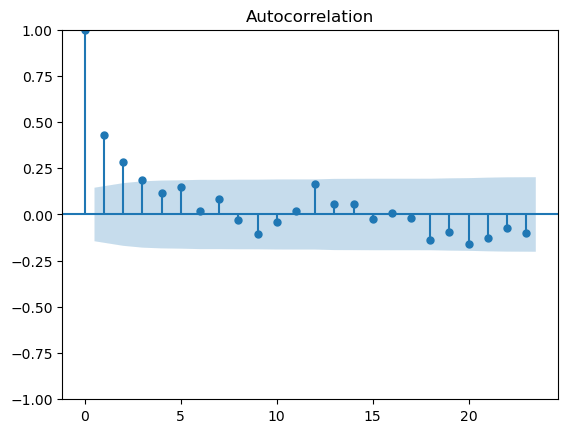

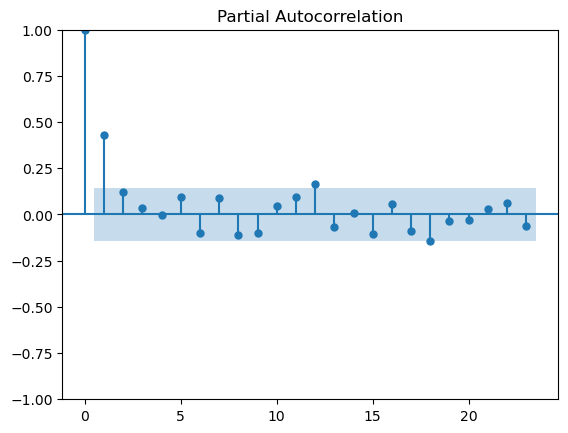

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train)
plot_pacf(train)
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 0, 0))
model_fit = model.fit()

In [49]:
history = train
predictions = list()
# walk-forward validation
for t in range(len(test),0,-1):
    model = ARIMA(sku1_data[:-t], order=(1,0,0));
    model_fit = model.fit();
    output = model_fit.forecast();
    yhat = output.iloc[0]
    predictions.append(yhat)

In [51]:
def evaluate(model, predictions, test):
    sumvalue=np.sum(test)
    mape=np.sum(np.abs((test - predictions)))/sumvalue*100
    accuracy=100-mape
    print('Accuracy:', round(accuracy,2),'%.')

In [53]:
evaluate(model_fit, predictions, test)

Accuracy: 62.8 %.


In [55]:
for product in sales_data['Product'].unique():
    print(product)
    sku_data = get_product_data(product)
    train, test = split(sku_data, 20)
    model = ARIMA(train, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = list()
    for t in range(len(test),0,-1):
        model = ARIMA(sku_data[:-t], order=(1,0,0));
        model_fit = model.fit();
        output = model_fit.forecast();
        yhat = output.iloc[0]
        predictions.append(yhat)
    evaluate(model_fit, predictions, test)

SKU1
Accuracy: 62.8 %.
SKU2
Accuracy: 41.42 %.
SKU3
Accuracy: 23.27 %.
SKU4
Accuracy: 28.08 %.
SKU5
Accuracy: 36.21 %.
SKU6
Accuracy: 98.42 %.


## Machine Leanring Models
### Random Forest

In [91]:
def get_product_data(product):
    product_data = sales_data[sales_data["Product"] == product].drop('Product', axis = 1)
    product_data['date'] = pd.to_datetime(product_data['date'])
    product_data['Month'] = product_data['date'].dt.month
    # We are doing box-cox transformation because this is what we found to be the best from EDA
    product_data['Sales'], _ = boxcox(product_data['Sales'] + 1)
    return product_data

In [93]:
sku1_data = get_product_data('SKU1')
sku1_data.head()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,Month
0,2017-02-05,349.792567,0.00,0,0,0,0.0,0,0,0,0,2
1,2017-02-12,357.876564,0.00,1,0,1,0.0,0,1,0,0,2
2,2017-02-19,450.577477,0.17,0,0,0,0.0,0,0,0,0,2
3,2017-02-26,343.567944,0.00,1,0,1,0.0,0,0,0,0,2
4,2017-03-05,431.961741,0.17,0,0,0,0.0,0,0,0,0,3


In [95]:
def split(data, test_length):
    test_length =test_length
    end_point = len(data)
    x = end_point - test_length
    train = data.loc[:x - 1, :]
    test = data.loc[x:, :]
    test_x = test.loc[:, test.columns != 'Sales']
    test_y = test['Sales']
    train_x = train.loc[:, train.columns != 'Sales']
    train_y = train['Sales']
    return test_x, test_y, train_x, train_y

In [97]:
def add_lag(data):
    dataframe = pd.DataFrame()
    for i in range(54, 0, -1):
       dataframe['t-' + str(i)] = data.Sales.shift(i)
    final_data = pd.concat([data, dataframe], axis=1)
    final_data.dropna(inplace=True)
    finaldf = final_data.drop(['date'], axis=1)
    finaldf = finaldf.reset_index(drop=True)
    return finaldf

In [99]:
df = add_lag(sku1_data)

In [101]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
def train(train_x, train_y, n, m):
    rfe = RFE(RandomForestRegressor(n_estimators=n, random_state=1), n_features_to_select=m)
    fit = rfe.fit(train_x, train_y)
    return fit

In [103]:
def evaluate(model, test_x, test_y):
    y_pred = model.predict(test_x)
    y_true = np.array(test_y)
    sumvalue=np.sum(y_true)
    mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
    accuracy=100-mape
    print('Accuracy:', round(accuracy,2),'%.')

In [105]:
test_x, test_y, train_x, train_y = split(df, 20)
model = train(train_x, train_y, 100, 10)
evaluate(model, test_x, test_y)

Accuracy: 43.1 %.


In [106]:
model.score(test_x, np.array(test_y))

-0.7253454201198624

In [107]:
for product in sales_data['Product'].unique():
    print(product)
    sku_data = get_product_data(product)
    test_stationarity(sku_data)
    df = add_lag(sku_data)
    test_x, test_y, train_x, train_y = split(df, 20)
    model = train(train_x, train_y, 100, 10)
    evaluate(model, test_x, test_y)

SKU1
p-value: 0.000036
Accuracy: 43.1 %.
SKU2
p-value: 0.000000
Accuracy: 56.07 %.
SKU3
p-value: 0.763558
Accuracy: 34.24 %.
SKU4
p-value: 0.108157
Accuracy: 39.76 %.
SKU5
p-value: 0.008489
Accuracy: 52.02 %.
SKU6
p-value: 0.000255
Accuracy: 98.87 %.


We tried transformation technique such as log, square root, and box-cox transformation to reduce the skewness as we can't remove those data points. But even after transformation the skewness seems to persist to some extent. Box-cox seems to help the most.

In [ ]:
We decide to use 

In [ ]:
# Random Forest

In [34]:
mobility = sales_data[['date', 'Google_Mobility']]
mobility.drop_duplicates(inplace=True)
mobility.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             204 non-null    datetime64[ns]
 1   Google_Mobility  204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26180\3405096298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobility.drop_duplicates(inplace=True)


By keeping only `date` and `Google_Mobility`, we can see that `Google_Mobility` is the same for each product on a given day, so we only need to analyze it once. We will just filter with `SKU1`.

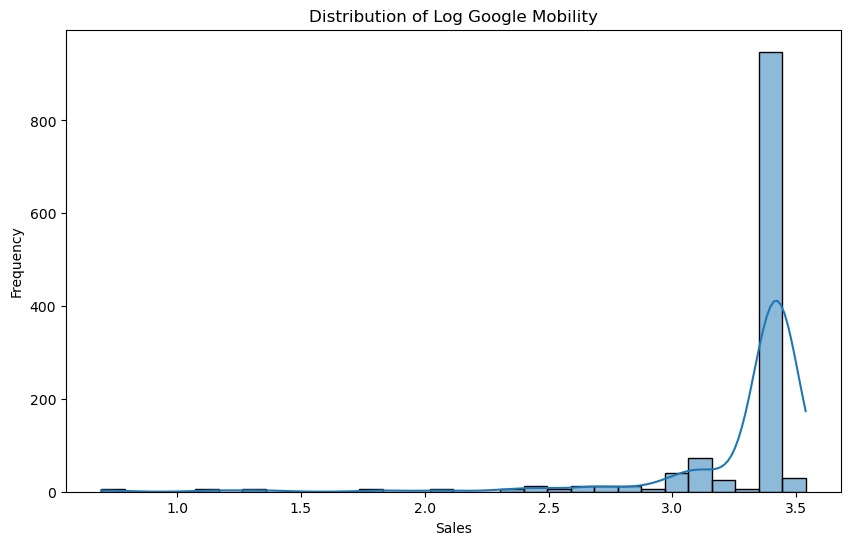

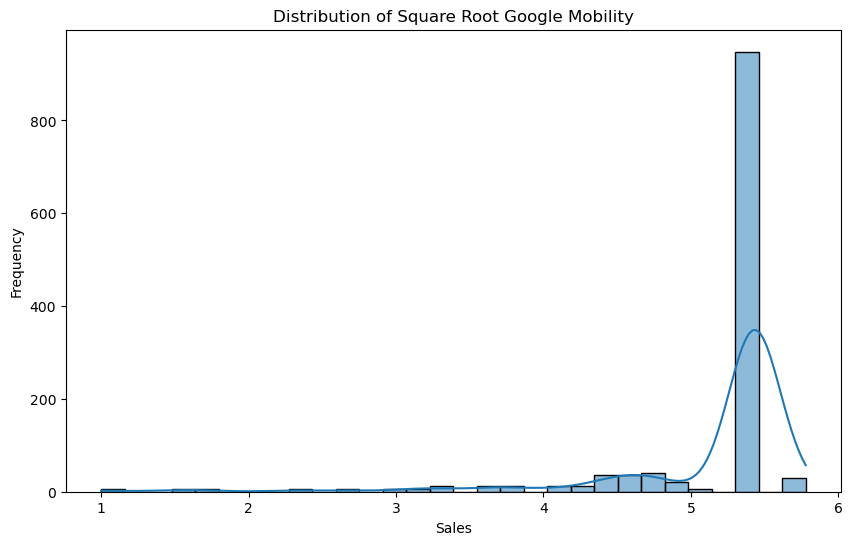

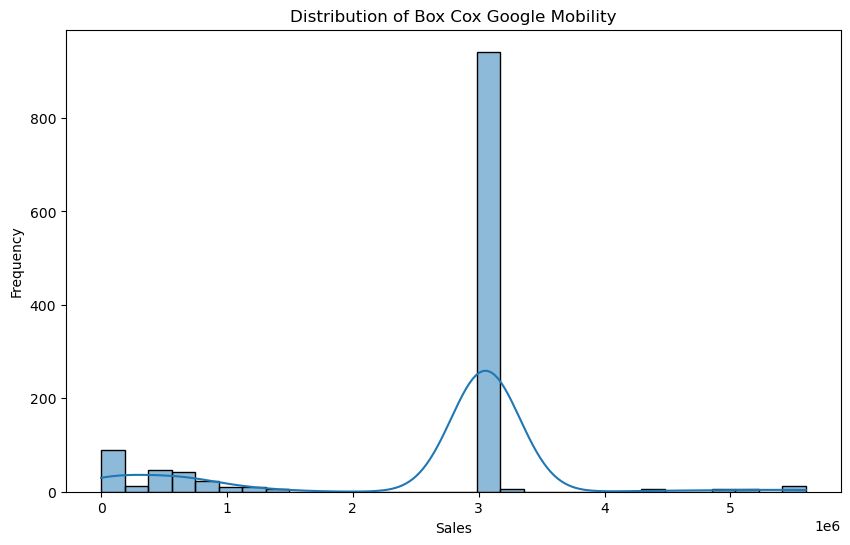

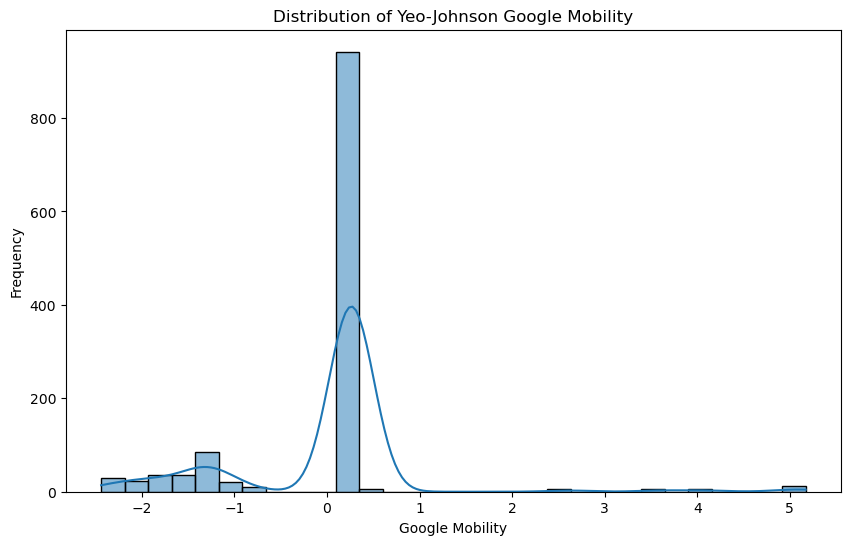

In [42]:
# Log for Google Mobility
sales_data['Google_Mobility_log'] = np.log1p(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)  # Shifting values to be positive

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_log'], kde=True, bins=30)
plt.title('Distribution of Log Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Square root for Google Mobility
sales_data['Google_Mobility__sqrt'] =np.sqrt(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility__sqrt'], kde=True, bins=30)
plt.title('Distribution of Square Root Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Box-Cox for Google Mobility (strictly positive data)
sales_data['Google_Mobility_boxcox'], _ = boxcox(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)  # Shift to be positive

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_boxcox'], kde=True, bins=30)
plt.title('Distribution of Box Cox Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Yeo-Johnson for Google Mobility (handles both positive and negative data)
pt = PowerTransformer(method='yeo-johnson')
sales_data['Google_Mobility_yeojohnson'] = pt.fit_transform(sales_data[['Google_Mobility']])

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_yeojohnson'], kde=True, bins=30)
plt.title('Distribution of Yeo-Johnson Google Mobility')
plt.xlabel('Google Mobility')
plt.ylabel('Frequency')
plt.show()

We tried transformation technique such as log, square root, box-cox and Yeo-Johnson transformation to reduce the skewness as we can't remove those data points. But even after transformation the skewness seems to persist to some extent. Though Yeo-Johnson seems to be the best technique to use.